In [75]:
import itertools
from datetime import datetime

import submitit 

from auto_circuit.tasks import (
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
)
from elk_experiments.utils import repo_path_to_abs_path, OUTPUT_DIR
from elk_experiments.auto_circuit.tasks import IOI_TOKEN_CIRCUIT_TASK
from auto_circuit.types import AblationType
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc

# Specify Settings / Hyperpameters

In [76]:
#specify the hyperparameters
tasks = [
    IOI_TOKEN_CIRCUIT_TASK, 
    IOI_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    # IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # ANIMAL_DIET_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK
]
use_abs = [True, False]
ablation_types = [
    AblationType.RESAMPLE, 
    AblationType.TOKENWISE_MEAN_CLEAN,
    AblationType.TOKENWISE_MEAN_CORRUPT, 
    AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT,
    # AblationType.ZERO
]
grad_funcs = [
    GradFunc.LOGIT, 
    GradFunc.LOGPROB
]
answer_funcs = [
    AnswerFunc.MAX_DIFF, 
    AnswerFunc.AVG_VAL
]

use_abs_to_epsilon = {
    True: [0.1], 
    False: [0.0, -0.4]
}

# generate all combinations
combinations = [
    {
        "task": f"'{task.key}'",
        "use_abs": use_ab,
        "ablation_type": ablation_type.name,
        "grad_func": grad_func.name,
        "answer_func": answer_func.name,
        "epsilon": epsilon
    }
    for task, use_ab, ablation_type, grad_func, answer_func in itertools.product(
        tasks,
        use_abs,
        ablation_types,
        grad_funcs,
        answer_funcs
    )
    for epsilon in use_abs_to_epsilon[use_ab]
]

# combinations = [
#     {
#         "task": f"'{IOI_TOKEN_CIRCUIT_TASK.key}'",
#         "use_abs": False,
#         "ablation_type": AblationType.TOKENWISE_MEAN_CORRUPT.name,
#         "grad_func": GradFunc.LOGPROB.name,
#         "answer_func": AnswerFunc.AVG_VAL.name,
#         "epsilon": 0.0
#     }
# ]

# Setup Executor and Run

In [3]:
# setup the executor
out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_out_logs" / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
out_dir.mkdir(exist_ok=True, parents=True)
executor = submitit.AutoExecutor(folder=out_dir)
num_jobs_parallel = 8
executor.update_parameters(
    timeout_min=60*24,
    mem_gb=40,
    gres="gpu:1",
    cpus_per_task=8,
    nodes=1,
    slurm_qos="high", 
    slurm_array_parallelism=num_jobs_parallel
)


/nas/ucb/oliveradk/miniforge3/envs/elk-experiments/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [4]:
# run the jobs
with executor.batch():
    jobs = []
    for combo in combinations:
        function = submitit.helpers.CommandFunction(
            ["python", "scripts/hypothesis_tests.py"] + [
                f"{key}={value}" for key, value in combo.items()
            ], 
            cwd=repo_path_to_abs_path(".")
        )
        jobs.append(executor.submit(function))

In [8]:
len(jobs)

48

In [9]:
job = jobs[47]
# read stdout and stderr
print(job.stdout())
# print(job.stderr())

submitit INFO (2024-08-14 15:22:36,045) - Starting with JobEnvironment(job_id=432143_47, hostname=ppo.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-08-14 15:22:36,045) - Loading pickle: /nas/ucb/oliveradk/elk-experiments/output/hypo_test_out_logs/2024-08-14_14-45-35/432143_47_submitted.pkl
The following command is sent: "python scripts/hypothesis_tests.py task='Indirect Object Identification Component Circuit' use_abs=False ablation_type=TOKENWISE_MEAN_CLEAN_AND_CORRUPT grad_func=LOGPROB answer_func=AVG_VAL epsilon=-0.4"
Loaded pretrained model gpt2-small into HookedTransformer
seq_len before divergence None
seq_len after divergence None
Saving cache to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Indirect_Object_Identification_Component_Circuit_TOKENWISE_MEAN_CLEAN_AND_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_-0.4_0.9/prune_scores-14-08-2024_15-23-13.pkl
interval: 0 - 32491
width 1000
interval: 32000 - 32491
width 100
interval: 32400 -

# Analysize Results

## Edge Counts

In [29]:
from auto_circuit.tasks import Task
def get_exp_dir(
    task_key: str,
    ablation_type: AblationType,
    grad_func: GradFunc,
    answer_func: AnswerFunc,
    ig_samples: int, 
    use_abs: bool,
    alpha: float,
    epsilon: float,
    q_star: float
):
    return repo_path_to_abs_path(
        OUTPUT_DIR / "hypo_test_results" / f"{task_key.replace(' ', '_')}_{ablation_type.name}_{grad_func.name}_{answer_func.name}_{ig_samples}" / f"{use_abs}_{alpha}_{epsilon}_{q_star}"
    )

In [30]:
def format_ablation_type(ablation_type: str):
    # remove TOKENWISE
    if ablation_type.startswith("TOKENWISE"):
        ablation_type = ablation_type[len("TOKENWISE_"):]
    # replace _ with space
    ablation_type = ablation_type.replace("_", " ")
    # upper case to title case
    ablation_type = ablation_type.title()
    return ablation_type

In [106]:
import pandas as pd
import json

ig_default = 10
alpha_default = 0.05
q_star_default = 0.9

# Create a list to store the data
data = []

for combo in combinations:
    task_key = combo["task"][1:-1]  # strip quotes
    ablation_type = AblationType[combo["ablation_type"]]
    grad_func = GradFunc[combo["grad_func"]]
    answer_func = AnswerFunc[combo["answer_func"]]
    use_ab = combo["use_abs"]
    epsilon = combo["epsilon"]

    # get path to results 
    exp_path = get_exp_dir(task_key, ablation_type, grad_func, answer_func, ig_default, use_ab, alpha_default, epsilon, q_star_default)

    # load equiv test results 
    with open(exp_path / "equiv_results.json", "r") as f:
        equiv_test_results: dict[int, dict] = json.load(f)

    total_edges = max([int(edge_count) for edge_count in equiv_test_results.keys()])
    equivs = [int(edge_count) for edge_count, result in equiv_test_results.items() if not result["not_equiv"]]
    min_equiv = min(equivs) if len(equivs) > 0 else total_edges

    # Append the data as a dictionary
    data.append({
        'task_key': task_key,
        'use_abs': use_ab,
        'epsilon': epsilon,
        'ablation_type': ablation_type.name,
        'answer_func': answer_func.name,
        'grad_func': grad_func.name,
        'frac_total_edges': min_equiv / total_edges,
        'min_equiv': min_equiv,
        'total_edges': total_edges
    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Set a multi-index
df.set_index(['task_key', 'use_abs', 'epsilon', 'ablation_type', 'answer_func', 'grad_func'], inplace=True)

### Edge Counts for all Tasks, All Partitions

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_fraction_edges(df):
    scale = 'log'  # or 'linear'

    def limit_image_size(fig, ax, max_size=65000):
        while True:
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            if width <= max_size and height <= max_size:
                break
            fig_size = fig.get_size_inches()
            fig.set_size_inches(fig_size[0] * 0.9, fig_size[1] * 0.9)
        return fig, ax

    # Get unique combinations
    use_abs = df.index.get_level_values('use_abs').unique()
    epsilons = df.index.get_level_values('epsilon').unique()
    ablation_types = df.index.get_level_values('ablation_type').unique()
    answer_funcs = df.index.get_level_values('answer_func').unique()
    grad_funcs = df.index.get_level_values('grad_func').unique()
    task_keys = df.index.get_level_values('task_key').unique()

    ablation_answer_combinations = list(itertools.product(ablation_types, answer_funcs, grad_funcs))

    for use_ab in use_abs:
        for epsilon in epsilons:
            fig, ax = plt.subplots(figsize=(16, 9), dpi=100)
            index = np.arange(len(task_keys))
            bar_width = 0.8 / len(ablation_answer_combinations)
            opacity = 0.8

            plotted_combinations = 0  # Counter for actually plotted combinations

            for i, combination in enumerate(ablation_answer_combinations):
                ablation_type, answer_func, grad_func = combination
                
                # Filter the DataFrame
                mask = (df.index.get_level_values('use_abs') == use_ab) & \
                       (df.index.get_level_values('epsilon') == epsilon) & \
                       (df.index.get_level_values('ablation_type') == ablation_type) & \
                       (df.index.get_level_values('answer_func') == answer_func) & \
                       (df.index.get_level_values('grad_func') == grad_func)
                
                subset = df[mask]
                
                if not subset.empty:
                    values = subset['frac_total_edges'].values
                    task_indices = np.array([np.where(task_keys == task)[0][0] for task in subset.index.get_level_values('task_key')])
                    
                    position = task_indices + (plotted_combinations - len(ablation_answer_combinations)/2 + 0.5) * bar_width
                    
                    ax.bar(position, values, bar_width,
                           alpha=opacity,
                           label=f'{ablation_type} & {answer_func} % {grad_func}')
                    
                    plotted_combinations += 1

            if plotted_combinations == 0:
                plt.close(fig)
                continue  # Skip to the next iteration if no data was plotted

            ax.set_xlabel('Tasks')
            ax.set_ylabel('Fraction of Total Edges')
            ax.set_title(f'Fraction of Total Edges by Task (use_ab={use_ab}, epsilon={epsilon})')
            ax.set_xticks(index)
            ax.set_xticklabels(task_keys, rotation=90, ha='center', fontsize=8)
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
            ax.set_yscale(scale)
            
            plt.tight_layout()
            plt.subplots_adjust(right=0.75)
            
            fig, ax = limit_image_size(fig, ax)
            
            plt.savefig(f'fraction_edges_use_ab_{use_ab}_epsilon_{epsilon}.png', 
                        bbox_inches='tight', 
                        dpi=100)
            plt.close(fig)

    print("All figures have been generated and saved.")

# Usage
plot_fraction_edges(df)

All figures have been generated and saved.


## Relative Edge Counts Across Paritions

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center', 
    custom_filters: Dict[str, List[Any]] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()

    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Create a mapping for sorted indices
    sorted_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(agg_data.index)}
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for _, row in agg_data.iterrows():
        i = sorted_indices[row.name]
        # Plot individual points with reduced opacity
        ax.scatter([i] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a bold point
        ax.scatter(i, row['mean'], color='red', s=100, zorder=3)
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    ax.set_title(f'Normalized {value_column} by {" and ".join(agg_by)}')
    ax.set_xticks(range(len(agg_data)))
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, label='Mean')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center',
    custom_filters: Dict[str, List] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate x-positions for evenly spaced columns
    num_columns = len(agg_data)
    x_positions = np.linspace(0.1, 0.9, num_columns)
    
    for i, (_, row) in enumerate(agg_data.iterrows()):
        # Plot individual points with reduced opacity
        ax.scatter([x_positions[i]] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a bold point
        ax.scatter(x_positions[i], row['mean'], color='red', s=100, zorder=3)
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    title = f'Normalized {value_column} by {" and ".join(agg_by)}'
    if custom_filters:
        filter_desc = ', '.join([f"{k}≠{v}" for k, v in custom_filters.items()])
        title += f' (Filtered: {filter_desc})'
    ax.set_title(title)
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set x-axis limits
    ax.set_xlim(0, 1)
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, label='Mean')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# flexible_normalize_aggregate_and_plot(
#     df,
#     agg_by=['ablation_type', 'answer_func', 'grad_func'],
#     value_column='frac_total_edges',
#     normalize_by=['task_key', 'use_abs', 'epsilon'],
#     rotation=45,
#     ha='right',
#     custom_filters={'epsilon': [-0.4]}
# )

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center',
    custom_filters: Dict[str, List] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate x-positions for evenly spaced columns, including phantom columns
    num_columns = len(agg_data)
    x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
    
    for i, (_, row) in enumerate(agg_data.iterrows()):
        # Plot individual points with reduced opacity
        ax.scatter([x_positions[i]] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a bold point
        ax.scatter(x_positions[i], row['mean'], color='red', s=100, zorder=3)
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    title = f'Normalized {value_column} by {" and ".join(agg_by)}'
    if custom_filters:
        filter_desc = ', '.join([f"{k}≠{v}" for k, v in custom_filters.items()])
        title += f' (Filtered: {filter_desc})'
    ax.set_title(title)
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set x-axis limits
    ax.set_xlim(0, 1)
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, label='Mean')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# flexible_normalize_aggregate_and_plot(
#     df,
#     agg_by=['ablation_type', 'answer_func', 'grad_func'],
#     value_column='frac_total_edges',
#     normalize_by=['task_key', 'use_abs', 'epsilon'],
#     rotation=45,
#     ha='right',
#     custom_filters={'epsilon': [-0.4]}
# )

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center',
    custom_filters: Dict[str, List] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', 'median', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate x-positions for evenly spaced columns, including phantom columns
    num_columns = len(agg_data)
    x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
    
    for i, (_, row) in enumerate(agg_data.iterrows()):
        # Plot individual points with reduced opacity
        ax.scatter([x_positions[i]] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a red point
        ax.scatter(x_positions[i], row['mean'], color='red', s=100, zorder=3, marker='o')
        
        # Plot median with a green triangle
        ax.scatter(x_positions[i], row['median'], color='green', s=100, zorder=3, marker='^')
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    title = f'Normalized {value_column} by {" and ".join(agg_by)}'
    if custom_filters:
        filter_desc = ', '.join([f"{k}≠{v}" for k, v in custom_filters.items()])
        title += f' (Filtered: {filter_desc})'
    ax.set_title(title)
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set x-axis limits
    ax.set_xlim(0, 1)
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, marker='o', label='Mean')
    ax.scatter([], [], color='green', s=100, marker='^', label='Median')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# flexible_normalize_aggregate_and_plot(
#     df,
#     agg_by=['ablation_type', 'answer_func', 'grad_func'],
#     value_column='frac_total_edges',
#     normalize_by=['task_key', 'use_abs', 'epsilon'],
#     rotation=45,
#     ha='right',
#     custom_filters={'epsilon': [-0.4]}
# )

### By Ablation Type

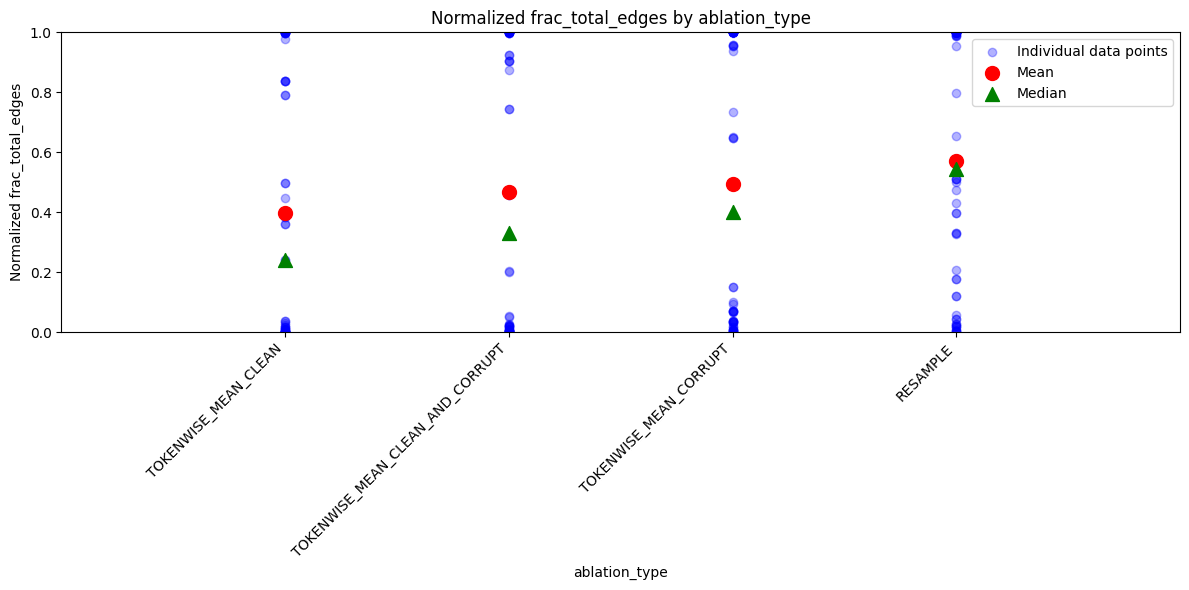

In [139]:
# Example usage:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right', 
)

thoughts - no clear winner, not too much data, though the fact that mean corrupt tends to be smaller does make sense (doesn't need to infer task)

### By Output Function (LogProb vs Logit)

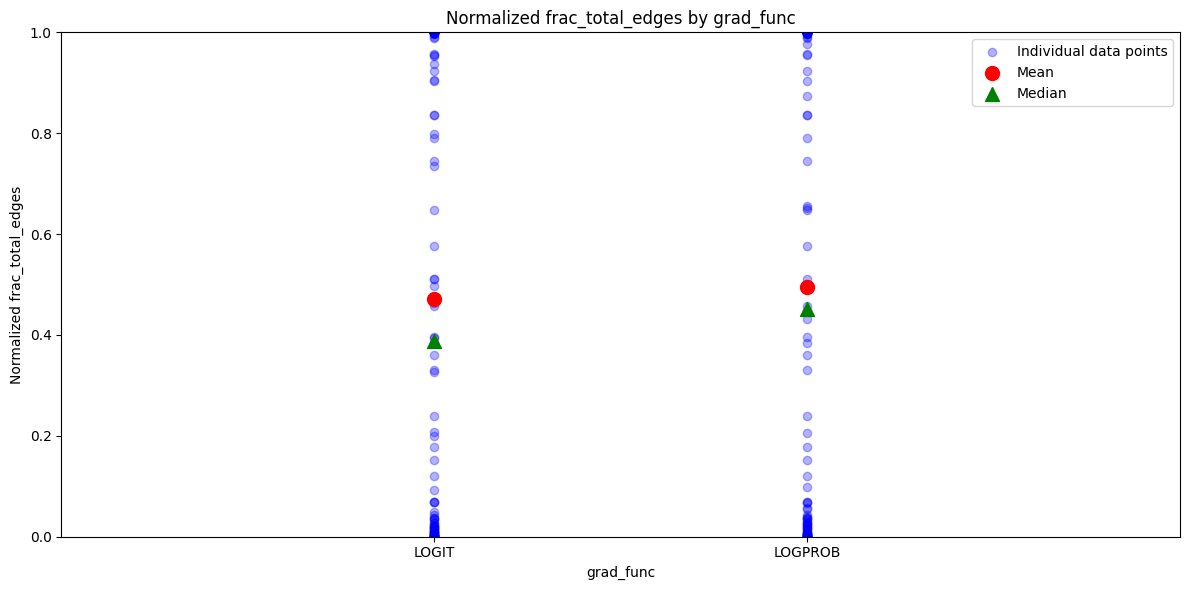

In [140]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

obviously no clear winners, but lots of variation

### Compare Answer Functions 

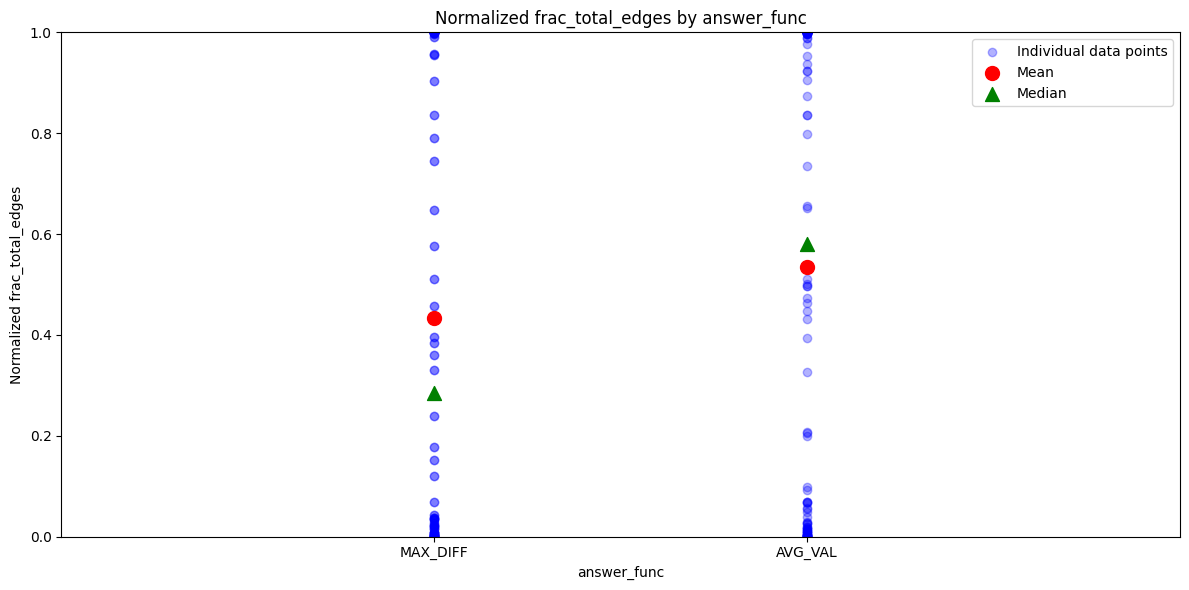

In [141]:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

I guess I would have predicted max diff would have more of an advantage - maybe I should be looking at token only? idk

### Output Function x Answer Function

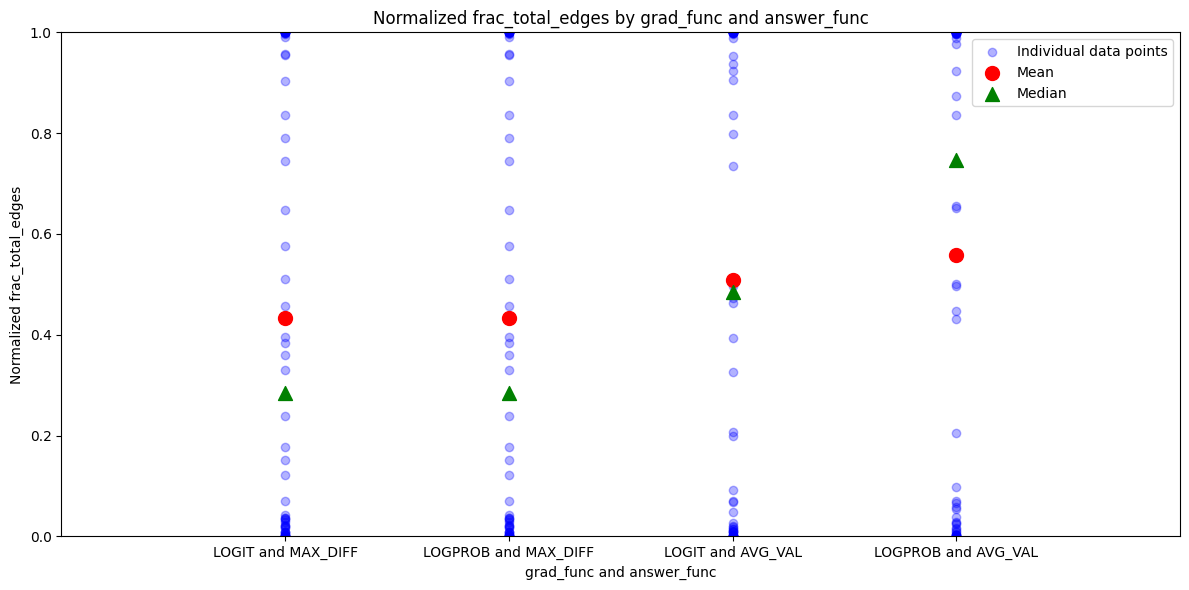

In [142]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

### Output Function x Answer Function x Ablation Type 

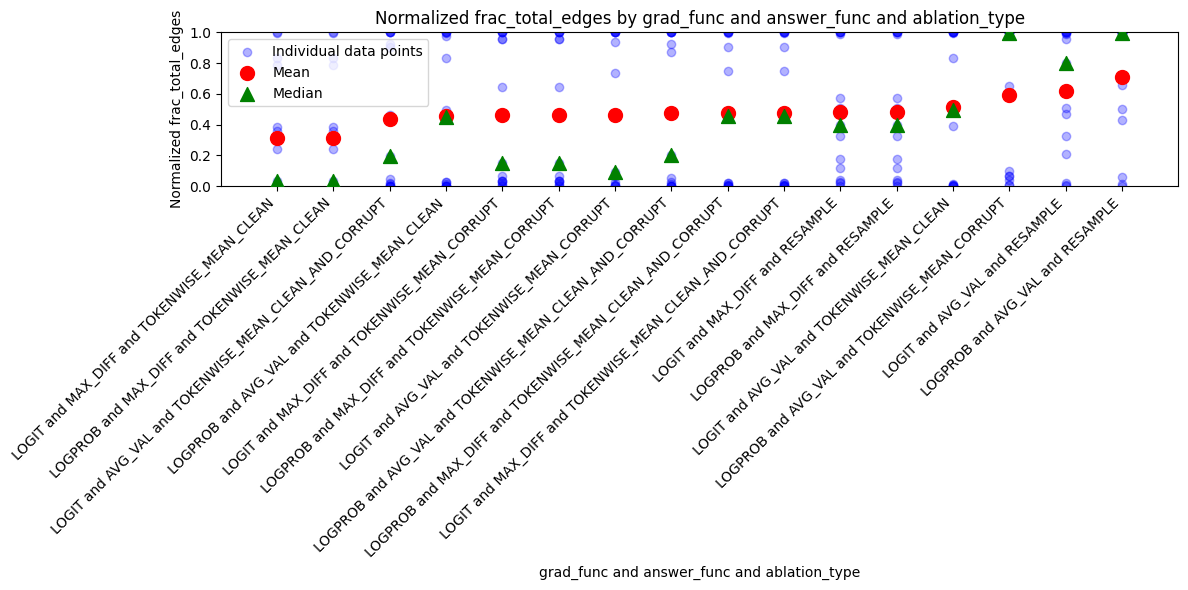

In [143]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func', 'ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right'
)

ok I could probably stare at it more but no super discernable synergies, seems like some methods are marignally "better", those difference roughly compound

### Abs vs Postive Only
What I want - aggregatae across 

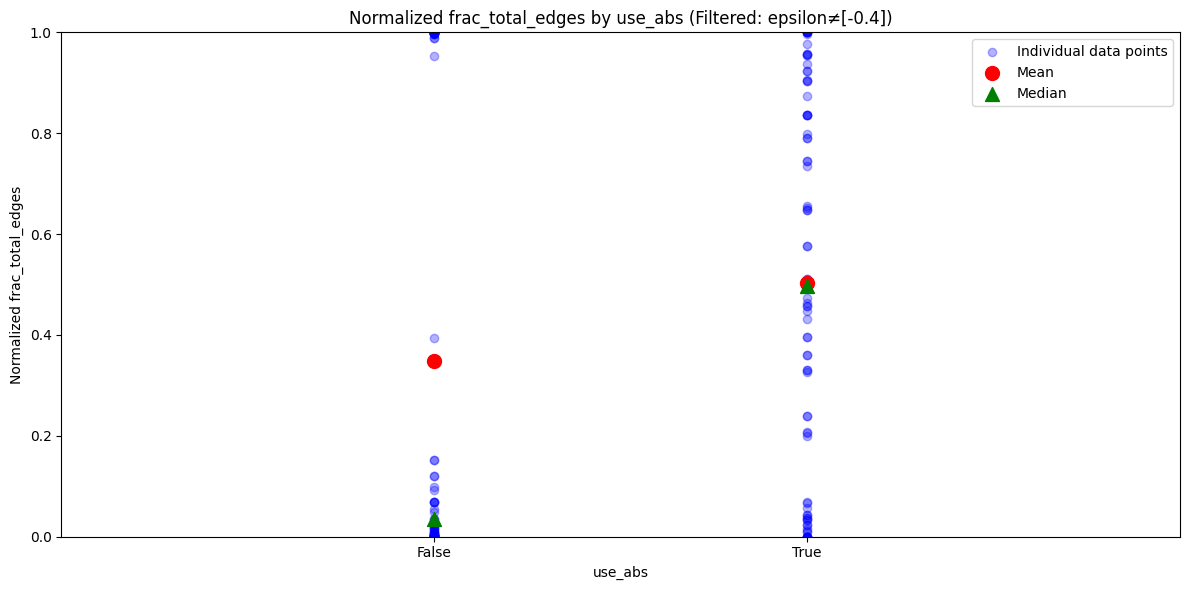

In [144]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['use_abs'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [-0.4]}
)

## Abs 0.0 vs 0.4 

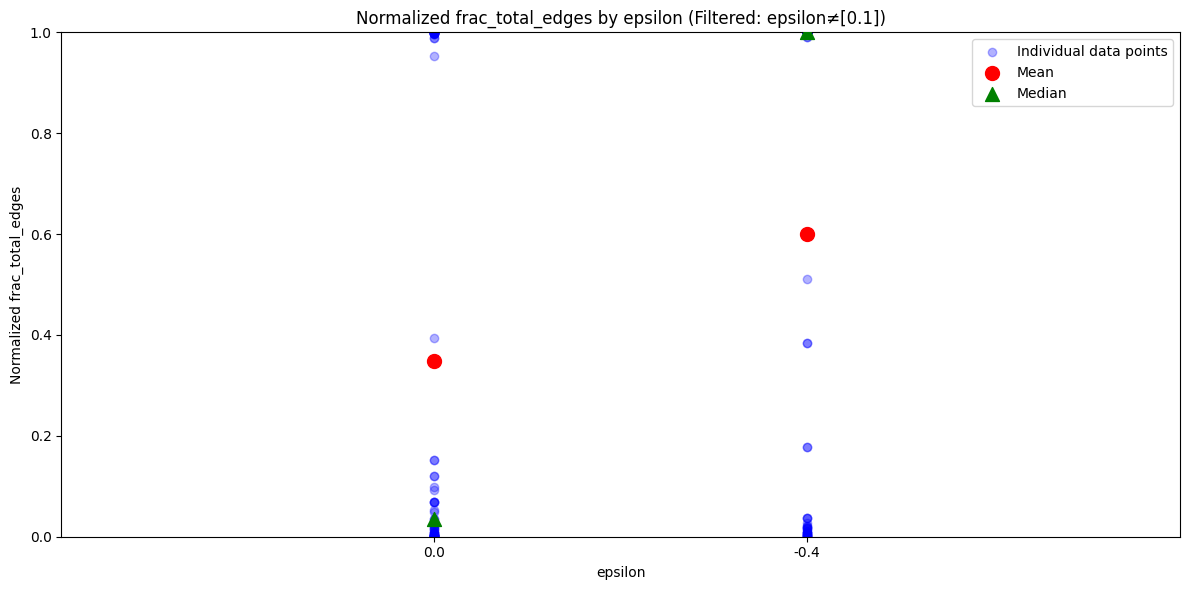

In [145]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['epsilon'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [0.1]}
)

## Minimality / Completeness Tradeoff